# DBSCAN

Algo que tienen en comun los algoritmos k-means y clustering jerárquico, y que comprende su principal debilidad es que los mismos está en el hecho de asumen una geometría esférica en la distribución de los datos. Lo que no siempre se cumple, por ejemplo:

In [1]:
from sklearn.datasets import make_moons
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN,KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist,squareform
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

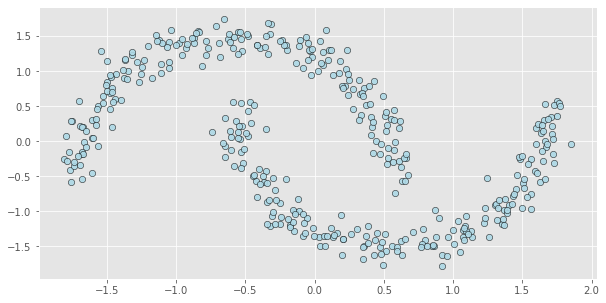

In [2]:
X, label = make_moons(n_samples=400, noise=0.07, random_state=19)

X= StandardScaler().fit_transform(X)

fig, ax = plt.subplots(figsize=(10,5))
sctr = ax.scatter(X[:,0],X[:,1], c='lightblue', edgecolor='black', s=40, alpha=0.9,
                 cmap=plt.cm.Set1)

### Clustering con kmeans

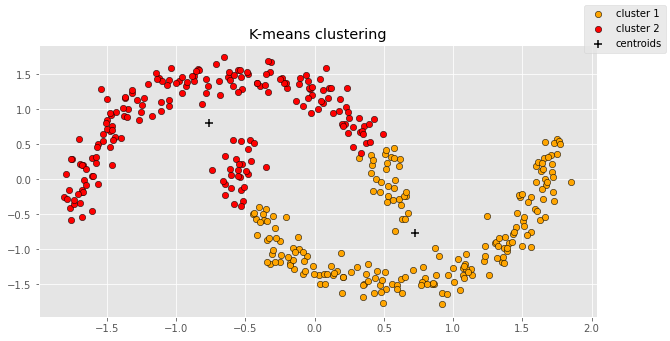

In [3]:
km = KMeans(n_clusters=2, random_state=19)
y_km = km.fit_predict(X)
#y_km # array de 1s y 0s.

centers=km.cluster_centers_;

fig, ax = plt.subplots(figsize=(10,5))
# hacemos una mascara con los y_km == 0 y y_km == 1, para obtener la posicion de los cluster 0 y 1 identificados.
ax.scatter(X[y_km==0,0], X[y_km==0,1],c ='orange', edgecolor='black', marker='o',s=40, label='cluster 1')
ax.scatter(X[y_km==1,0], X[y_km==1,1],c ='red', edgecolor='black', marker='o',s=40, label='cluster 2')
ax.scatter(centers[0,0],centers[0,1] ,marker='+',c='k',s=60)
ax.scatter(centers[1,0],centers[1,1] ,marker='+',c='k',s=60,label='centroids')
ax.set_title('K-means clustering')
fig.legend();

### Clustering con DBSCAN

Dbscan (Density Based Spatial Clustering of Applications with Noise) es un algoritmo que, como su nombre lo indica, identifica clusters como regiones de alta densidad de puntos. El algoritmo tiene dos hiperparámetros: 

* Eps ($\epsilon$): un radio para definir la densidad local de cada punto

* minPts: número mínimo de puntos dentro del radio para considerar que un punto es de tipo <i>core</i>.

Se definen tres tipos de puntos:

* Core: puntos que tienen más de N vecinos dentro de un radio Eps. Es decir, son puntos de alta densidad.

* Border: puntos que están dentro del radio de un punto core, pero ellos no cumplen la condición de core. Son las fronteras de los clusters.

* Noise: puntos que no cumplen la condición de core ni de border. Son outliers, o ruido, y no pertenecen a ningún cluster.

<img src='img/dbscan.png' style='background-color:white'>

#### El algoritmo se puede abstraer en estos tres pasos:



1) Etiquetar cada punto como core o non-core viendo si el número de vecinos en un radio Eps es mayor a minPts.
    
2) Encontrar las componentes conectadas por puntos core y asignarles un número de cluster a cada una.

3) Asignar el número del cluster más cercano a cada punto non-core, si se encuentra a una distancia menor a Eps. Si no, etiquetarlo como noise.



*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


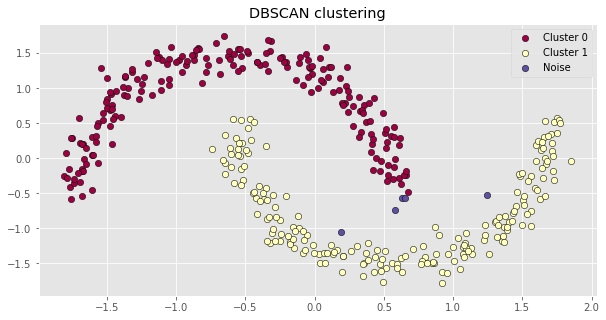

In [4]:
# Implementación de DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=5)
y_dbscan = dbscan.fit_predict(X)
#y_dbscan # array con las etiquetas 0 y 1.

# Lista de los puntos core y máscara para graficar
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

labels = dbscan.labels_ # array de etiquetas
unique_labels=set(labels) # para obtener las etiquetas {-1,0,1}

fig, ax = plt.subplots(figsize=(10,5))

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for i,l in enumerate(unique_labels):
    if l ==-1:
        ax.scatter(X[labels==l,0], X[labels==l,1],c =colors[i], edgecolor='black', marker='o',s=40,label='Noise')
    else:
        ax.scatter(X[labels==l,0], X[labels==l,1],c =colors[i], edgecolor='black', marker='o',s=40,label='Cluster '+str(l))
    
ax.legend()
ax.set_title('DBSCAN clustering');
    

In [5]:
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Calinsky-Harabasz Index: %0.3f" % calinski_harabasz_score(X, labels))

Silhouette Coefficient: 0.054
Calinsky-Harabasz Index: 177.500


### Ventajas de DBSCAN

* No es necesario definir el número de clusters a priori.

* Permite encontrar clusters con forma arbitraria, no necesariamente con geometría esférica.

* Al incluir la noción de ruido, dbscan el robusto ante la presencia de outliers.

* Tiene sólo dos hiperparámetros, fáciles de interpretar, que se pueden definir a priori en base a conocimientos del dominio de los datos.

### Desventajas 

* No es totalmente determinista: los puntos-borde que están a distancia menor a eps de más de un cluster podrían cambiar de etiqueta según el algoritmo de implementación.

* La performance disminuye en casos en donde la densidad de puntos varía mucho según la región ya que no se pueden ajustar los parámetros minPts y eps adecuadamente para todos los clusters.

* Si no se conocen bien los datos y su escala puede ser dificil determinar $\epsilon$.

### Elección de los parámetros $\epsilon$ y minPts ()

[Referencia](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation)


Idealmente, si se tiene conocimiento del dominio de los datos, $\epsilon$ es una distancia típica con sentido físico y minPts es el tamaño mínimo para los clusters. Si no, existen algunas heurísticas para determinar valores razonables:

* <b>MinPts:</b> Una regla de pulgar es asignar este parámetro en función del número de dimensiones $D$ en el dataset, como minPts $\ge$ D+1. minPts = 1 no tiene sentido, ya que cada punto sería un cluster de tamaño 1.  Con minPts $\le$ 2 el resultado es mismo que el de clustering jerárquico usando single linkage, cortando el dendrograma a una altura $\epsilon$ . En general minPts se elige mayor a 3 y una manera usual de determinarlo es <b>minPts=2D</b>, pero puede ser necesario usar valores mayores para datasets muy grandes, ruidosos o con datos duplicados.

* <b>$\epsilon$:</b> Se puede determinar mirando un gráfico de distancias al k-ésimo vecino, con k=minPts-1. Se calcula la distancia al k-ésimo vecino más cercano de cada punto y luego se grafican estas distancias de mayor a menor. Una buena elección de $\epsilon$ es en el codo o punto de quiebre de la curva. La elección de $\epsilon$ dependerá fuertemente de la métrica de distancias que se use, la cual debe determinarse antes.


<b> Ejemplo de curva de distancias k-ésimas: </b>

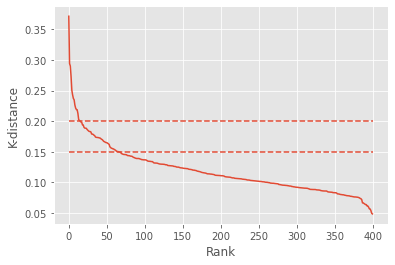

In [6]:
minPts=5;
k=minPts-1;

D=squareform(pdist(X));

k_distances=np.zeros(D.shape[0]);

for i in range(D.shape[0]):
    distances=np.sort(D[i]);
    k_distances[i]=distances[k];
k_distances=np.sort(k_distances);
k_distances=k_distances[::-1];
    
plt.plot(k_distances);
plt.xlabel('Rank');
plt.ylabel('K-distance');
plt.hlines([0.2,0.15],0,400,linestyles='dashed');

Una elección de $\epsilon$ entre 0.15 y 0.20 parece ser apropiada.


Aquí tienen unas buenas visualizaciones de DBSCAN y KMeans:

https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/